In [1]:
import sys
sys.path.append('../../../')
sys.path.append('../../')
sys.path.append('../')
import seaborn as sns 
from multiprocessing import Process
from omegaconf import OmegaConf
from core.run_lib import *
import numpy as np 
from core.passive_learning import *
from core.auto_labeling import *
from datasets import dataset_factory 
from datasets.dataset_utils import * 
from utils.common_utils import * 
from utils.vis_utils import *
from core.run_lib import * 
import copy 
import random 
from datasets.numpy_dataset import * 


root_dir = '../../../'
conf_dir = f'{root_dir}configs/calib-exp/'

base_conf_file = '{}/mnist_lenet_base_conf.yaml'.format(conf_dir)
conf           = OmegaConf.load(base_conf_file)

#training_conf  = OmegaConf.load('{}/training_confs/squentropy_training_conf.yaml'.format(conf_dir))
#conf.training_conf = training_conf

root_pfx       = 'mnist_lenet_calib-exp-runs'
root_pfx       = f'{root_dir}/outputs/{root_pfx}/'


conf['root_pfx']    = root_pfx

logger   = get_logger('../../../temp/logs/act_lbl_test.log',stdout_redirect=True,level=logging.DEBUG)


In [2]:
conf['train_pts_query_conf']['seed_train_size']= 10 
conf['train_pts_query_conf']['max_num_train_pts']= 50

set_seed(conf['random_seed'])

dm = DataManager(conf,logger,lib=conf['model_conf']['lib'])

print(len(dm.ds_std_train), len(dm.ds_std_val))

pl = PassiveLearning(conf,dm,logger)

out = pl.run()

w = pl.cur_clf.get_weights()
print(torch.norm(w))
test_err = get_test_error(pl.cur_clf,dm.ds_std_test,conf['inference_conf'])
print(test_err)

[09/15/2023 02:58:45 AM : DEBUG : data_manag : ] : torch.Size([42000, 28, 28])
[09/15/2023 02:58:45 AM : INFO  : data_manag : ] : Loaded dataset mnist
[09/15/2023 02:58:45 AM : INFO  : data_manag : ] : Std train size: 42000 and Std. Val. Size:18000
42000 18000
[09/15/2023 02:58:45 AM : DEBUG : passive_le : ] : Querying 10 seed training points
[09/15/2023 02:58:45 AM : DEBUG : passive_le : ] : Queried 10 seed points for training
[09/15/2023 02:58:45 AM : DEBUG : passive_le : ] : Validation Data Size :5000
[09/15/2023 02:58:45 AM : DEBUG : passive_le : ] : Querying rest of the training points 40 in single batch
[09/15/2023 02:58:45 AM : INFO  : passive_le : ] : Labeled data size for training: 50
[09/15/2023 02:58:45 AM : INFO  : pytorch_cl : ] : {'model_name': 'lenet', 'num_classes': 10, 'fit_intercept': True, 'lib': 'pytorch'}
[09/15/2023 02:58:45 AM : INFO  : passive_le : ] : --------------- Begin Model Training ------------
[09/15/2023 02:58:45 AM : INFO  : passive_le : ] : Training c

In [3]:
print(dm.ds_std_test.X.shape )

torch.Size([10000, 28, 28])


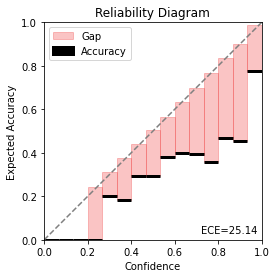

In [3]:
cur_val_ds,cur_val_idcs    = dm.get_current_validation_data()

val_inf_out = pl.cur_clf.predict(cur_val_ds,conf['inference_conf'])
bin_data = compute_calibration(cur_val_ds.Y, val_inf_out['labels'], val_inf_out['confidence'], num_bins=15)
ax = plt.subplot()
reliability_diagram_subplot(ax, bin_data, draw_ece=True, draw_bin_importance=False, title="Reliability Diagram", 
                             xlabel="Confidence", ylabel="Expected Accuracy",disable_labels=False)

<AxesSubplot:ylabel='Density'>

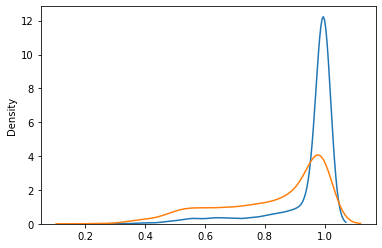

In [4]:
from utils.counting_utils import * 

out = get_scores_numbers(val_inf_out, cur_val_ds.Y,10)

sns.kdeplot(out['correct_scores'])
sns.kdeplot(out['incorrect_scores'])


In [5]:
dm.unmark_auto_labeled()
conf.auto_lbl_conf.C_1 = 0.25
conf.auto_lbl_conf.auto_label_err_threshold=0.05 
auto_labeler = AutoLabeling(conf,dm,pl.cur_clf,logger)
out = auto_labeler.run()
out = dm.get_auto_labeling_counts()
print(out)

[09/15/2023 02:59:31 AM : INFO  : auto_label : ] : ========================= Begin Auto-Labeling selective ==========================
[09/15/2023 02:59:31 AM : DEBUG : auto_label : ] : Auto Labeling Conf : {'method_name': 'selective', 'score_type': 'confidence', 'class_wise': 'independent', 'auto_label_err_threshold': 0.05, 'C_1': 0.25, 'ucb': 'sigma', 'fast': True}
[09/15/2023 02:59:31 AM : INFO  : auto_label : ] : Number of unlabeled points : 41950


[09/15/2023 02:59:32 AM : INFO  : auto_label : ] : Using number of validation points : 5000
[09/15/2023 02:59:32 AM : INFO  : auto_label : ] : Using Auto-Labeling Error Threshold = 0.05
[09/15/2023 02:59:32 AM : DEBUG : auto_label : ] : Expected Calibration Error on Validation set : 0.25143578700423247
[09/15/2023 02:59:32 AM : INFO  : auto_label : ] : Determining Thresholds : Class Wise : independent
[09/15/2023 02:59:32 AM : DEBUG : threshold_ : ] : C_1 = 0.25 UCB = sigma
[09/15/2023 02:59:32 AM : INFO  : threshold_ : ] : auto-labeling threshold t_i=0.92313152551651 for class 0   
[09/15/2023 02:59:32 AM : INFO  : threshold_ : ] : auto-labeling threshold t_i=0.9997071623802185 for class 1   
[09/15/2023 02:59:32 AM : INFO  : threshold_ : ] : auto-labeling threshold t_i=0.9984827637672424 for class 2   
[09/15/2023 02:59:33 AM : INFO  : threshold_ : ] : auto-labeling threshold t_i=0.9987831711769104 for class 3   
[09/15/2023 02:59:33 AM : INFO  : threshold_ : ] : auto-labeling thresh